In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

In [2]:
# coefficients
a = 1.0
b = 1e8
c = 1.0

# bad formula
disc = np.sqrt(b**2 - 4*a*c)
xminusbad = (-b - disc) / (2*a)
xplusbad  = (-b + disc) / (2*a)

# good formula (avoid catastrophic cancellation)
xplusgood = c / (a * xminusbad)

print(f"x-  (bad) = {xminusbad:.17g}")
print(f"x+  (bad) = {xplusbad:.17g}")
print(f"x+ (good) = {xplusgood:.17g}")

x-  (bad) = -100000000
x+  (bad) = -7.4505805969238281e-09
x+ (good) = -1e-08


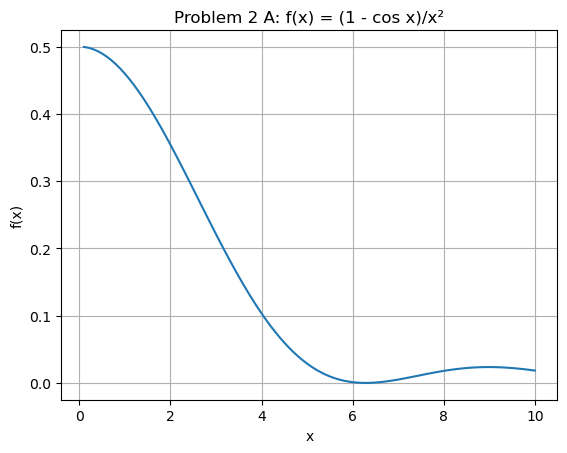

Limit as x→0 = 0.5
Naive f(1.2e-8) = 0.7709882115452477
Stable  f(1.2e-8) = 0.5


In [3]:
f = lambda x: (1 - np.cos(x)) / x**2
g = lambda x: 2 * (np.sin(x/2)**2) / x**2   # stable form

# (A) plot for x = 0.1*i
x = np.linspace(0.1, 10, 100)
plt.plot(x, f(x))
plt.title("Problem 2 A: f(x) = (1 - cos x)/x²")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.show()

# (B) limit x->0 using L’Hôpital -> 1/2
print("Limit as x→0 =", 0.5)

# (C) evaluate at x = 1.2e-8
xsmall = 1.2e-8
print("Naive f(1.2e-8) =", f(xsmall))
print("Stable  f(1.2e-8) =", g(xsmall))

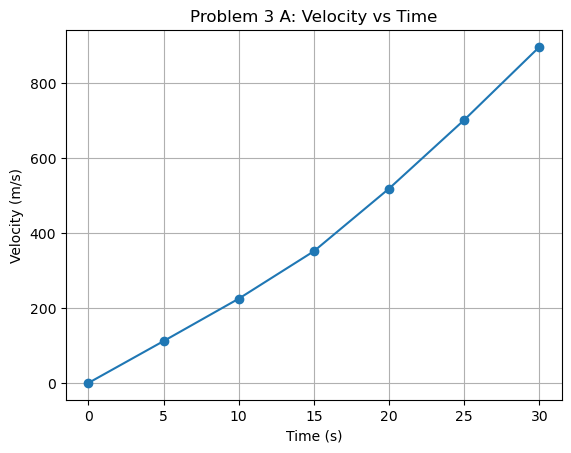

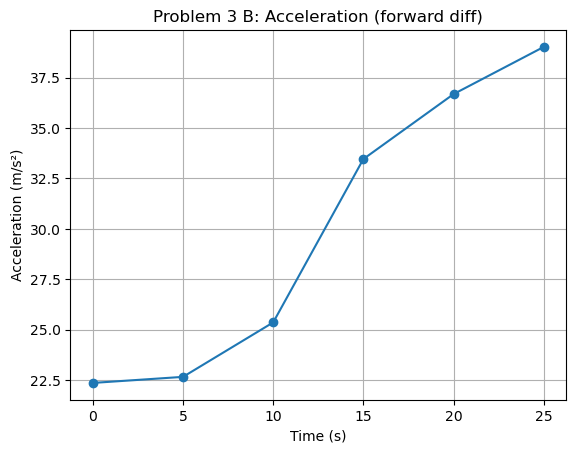

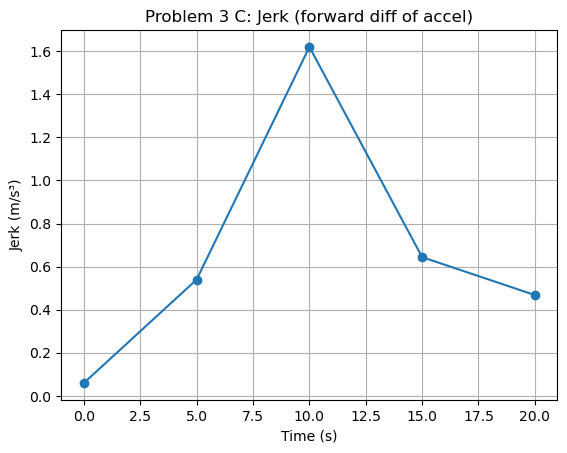

Maximum jerk = 1.6200000000000039


In [4]:
t = np.array([0,5,10,15,20,25,30], float)
v = np.array([0.0,111.8,225.1,351.9,519.2,702.6,897.7], float)

# (A) velocity vs time
plt.plot(t, v, 'o-')
plt.title("Problem 3 A: Velocity vs Time")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.grid(True)
plt.show()

# (B) forward-difference acceleration
a = np.diff(v)/np.diff(t)
ta = t[:-1]
plt.plot(ta, a, 'o-')
plt.title("Problem 3 B: Acceleration (forward diff)")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.grid(True)
plt.show()

# (C) jerk = forward diff of acceleration
j = np.diff(a)/np.diff(ta)
tj = t[:-2]
plt.plot(tj, j, 'o-')
plt.title("Problem 3 C: Jerk (forward diff of accel)")
plt.xlabel("Time (s)")
plt.ylabel("Jerk (m/s³)")
plt.grid(True)
plt.show()

print("Maximum jerk =", np.max(np.abs(j)))

Four and five gave me some issues; had to review and add in-depth comments to explain step by step (mainly for me)

Analytic f''(x₀) = -0.08333355358547401


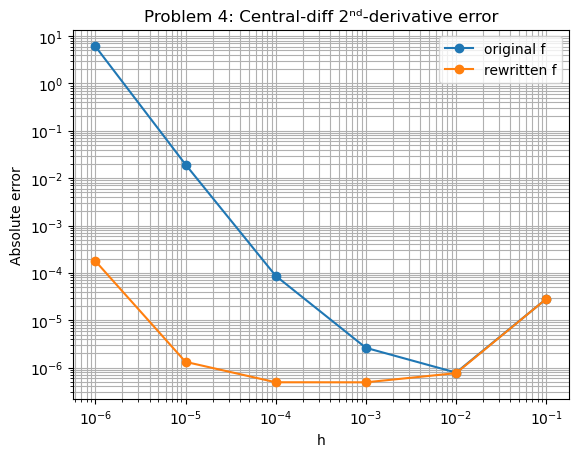

In [5]:
x = sp.symbols('x') # declares x as a symbolic variable 
fsym = (1 - sp.cos(x)) / x**2 # defines f(x)= (1-cosx)/x**2
f2sym = sp.diff(fsym, x, 2) # takes second derivative
f2 = sp.lambdify(x, f2sym, 'numpy') # converts symbolic expression into a numerical function

f = lambda x: (1 - np.cos(x)) / x**2 # original function
fre = lambda x: 2*(np.sin(x/2)**2)/x**2 # rewritten version using the trig identity

x0 = 0.004 
trueval = f2(x0) # evaluate the exact (symbolic) second derivative at that point
print("Analytic f''(x₀) =", trueval)

# central-difference error
hs = 10.0**(-np.arange(1,7)) # creates array
err, errre = [], [] # store absolute errors

for h in hs: # loop over each step size and compute central difference approx
    cd  = (f(x0+h) - 2*f(x0) + f(x0-h)) / h**2 # 
    cd2 = (fre(x0+h) - 2*fre(x0) + fre(x0-h)) / h**2
    err.append(abs(cd-trueval))
    errre.append(abs(cd2-trueval))

plt.loglog(hs, err, 'o-', label='original f')
plt.loglog(hs, errre, 'o-', label='rewritten f')
plt.title("Problem 4: Central-diff 2ⁿᵈ-derivative error")
plt.xlabel("h")
plt.ylabel("Absolute error")
plt.legend()
plt.grid(True, which='both')
plt.show()

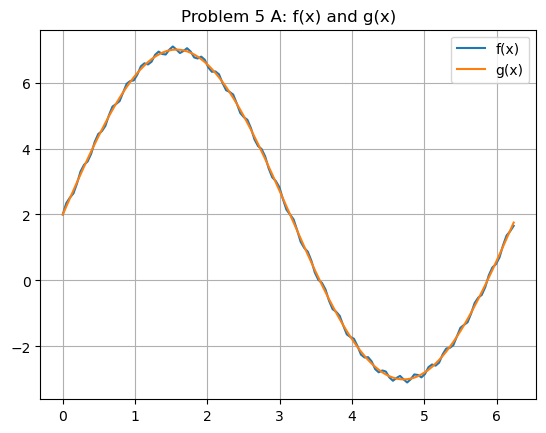

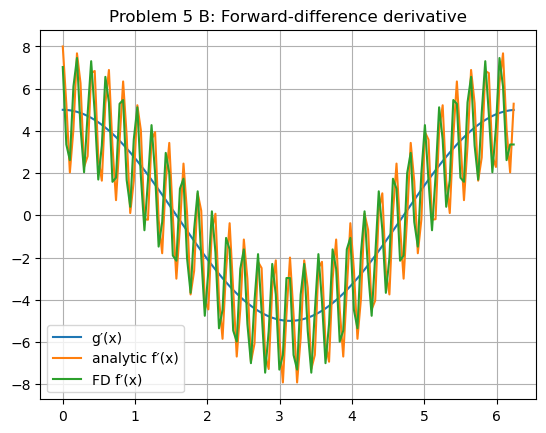

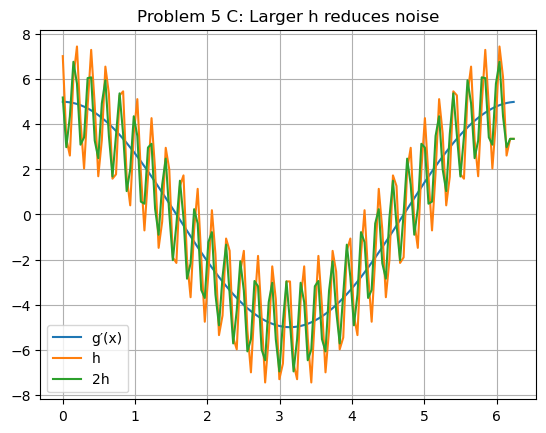

Best smoothing window = 21 (RMSE ≈ 1.02)


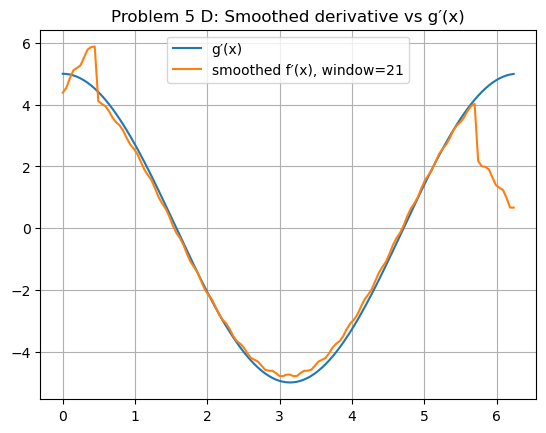

In [6]:
N = 128
x = np.linspace(0, 2*np.pi, N, endpoint=False) # create 128 spaced points between 0, 2pi
f = 2 + 5*np.sin(x) + 0.1*np.sin(30*x) # define noisy function, last term 0.1sin(30x) adds small, fast oscillations (“noise”)
g = 2 + 5*np.sin(x)

# (A) plot f and g
plt.plot(x, f, label="f(x)")
plt.plot(x, g, label="g(x)")
plt.legend(); plt.grid(True)
plt.title("Problem 5 A: f(x) and g(x)")
plt.show()

# analytic derivatives
fp = 5*np.cos(x) + 3*np.cos(30*x) 
gp = 5*np.cos(x)

# (B) forward-difference derivative
h = x[1]-x[0]
fd = np.concatenate(((f[1:]-f[:-1])/h, [(f[-1]-f[-2])/h]))

plt.plot(x, gp, label="g′(x)")
plt.plot(x, fp, label="analytic f′(x)")
plt.plot(x, fd, label="FD f′(x)")
plt.legend(); plt.grid(True)
plt.title("Problem 5 B: Forward-difference derivative")
plt.show()

# (C) larger step (twice-removed)
fd2 = np.empty_like(f) # create a new derivative estimate using two steps apart
fd2[:-2] = (f[2:] - f[:-2]) / (2*h)
fd2[-2:] = fd[-2:]
plt.plot(x, gp, label="g′(x)")
plt.plot(x, fd, label="h")
plt.plot(x, fd2, label="2h")
plt.legend(); plt.grid(True)
plt.title("Problem 5 C: Larger h reduces noise")
plt.show()

# (D) moving-average smoothing
def smooth(y, w): # defines moving average smoother 
    k = np.ones(w)/w
    return np.convolve(y, k, mode='same')

windows = range(1, 32, 2) # try odd window sizes 
best, bestrmse = None, 1e9
for w in windows:
    s = smooth(f, w)
    sfd = np.concatenate(((s[1:]-s[:-1])/h, [(s[-1]-s[-2])/h]))
    rmse = np.sqrt(np.mean((sfd - gp)**2))
    if rmse < bestrmse: # keep the window with the lowest rmse
        bestrmse, best, bestfd = rmse, w, sfd

print(f"Best smoothing window = {best} (RMSE ≈ {bestrmse:.3g})")

plt.plot(x, gp, label="g′(x)")
plt.plot(x, bestfd, label=f"smoothed f′(x), window={best}")
plt.legend(); plt.grid(True)
plt.title("Problem 5 D: Smoothed derivative vs g′(x)")
plt.show()